In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

In [3]:
folder_path = "../test"

In [7]:
image_files = []
for file in os.listdir(folder_path):
    if file.endswith(".jpg"):
        image_files.append(os.path.join(folder_path, file))
    #endif
#endfor

len(image_files)

391

In [9]:
def load_yolo(weights_files, cfg_file, names_files):
    nets = []
    classes_list = []
    output_layers_list = []
    colors_list = []

    for weights_file, names_file in zip(weights_files, names_files):
        net = cv2.dnn.readNet(weights_file, cfg_file)
        nets.append(net)

        with open(names_file, "r") as f:
            classes = [line.strip() for line in f.readlines()]
        classes_list.append(classes)

        layer_names = net.getLayerNames()
        output_layers = []
        for i in net.getUnconnectedOutLayers():
            output_layers.append(layer_names[i-1])
        #endfor

        output_layers_list.append(output_layers)

        colors = np.random.uniform(0, 255, size=(len(classes), 3))
        colors_list.append(colors)
    #endfor

    return nets, classes_list, colors_list, output_layers_list
#enddef

def detect_objects(img, net, outputLayers):
    blob = cv2.dnn.blobFromImage(img, scalefactor=0.00392, size=(416, 416), mean=(0, 0, 0), swapRB=True, crop=False)
    net.setInput(blob)
    outputs = net.forward(outputLayers)
    return blob, outputs
#enddef

def get_box_dimensions(outputs, height, width):
    boxes = []
    confs = []
    class_ids = []
    for output in outputs:
        for detect in output:
            scores = detect[5:]
            class_id = np.argmax(scores)
            conf = scores[class_id]
            if conf > 0.2:
                center_x = int(detect[0] * width)
                center_y = int(detect[1] * height)
                w = int(detect[2] * width)
                h = int(detect[3] * height)
                x = int(center_x - w/2)
                y = int(center_y - h / 2)
                boxes.append([x, y, w, h])
                confs.append(float(conf))
                class_ids.append(class_id)
            #endif
        #endfor
    #endfor
    return boxes, confs, class_ids
#enddef

def calculate_iou(box1, box2):
    x1, y1, w1, h1 = box1
    x2, y2, w2, h2 = box2
    
    x_left = max(x1, x2)
    y_top = max(y1, y2)
    x_right = min(x1 + w1, x2 + w2)
    y_bottom = min(y1 + h1, y2 + h2)
    
    if x_right < x_left or y_bottom < y_top:
        return 0.0
    #endif
    
    intersection_area = (x_right - x_left) * (y_bottom - y_top)
    
    box1_area = w1 * h1
    box2_area = w2 * h2
    
    iou = intersection_area / float(box1_area + box2_area - intersection_area)
    return iou
#enddef

def draw_labels_iou(boxes, confs, colors, class_ids, classes, img, iou_threshold=0.1):
    font = cv2.FONT_HERSHEY_PLAIN
    for i in range(len(boxes)):
        if boxes[i] is None:
            continue
        #endif

        x_i, y_i, w_i, h_i = boxes[i]
        label_i = str(classes[class_ids[i]])
        color_i = (0,255,0)#colors[class_ids[i]]
        
        for j in range(i + 1, len(boxes)):
            if boxes[j] is None or class_ids[j] != class_ids[i]:
                continue
            #endif
            x_j, y_j, w_j, h_j = boxes[j]
            
            iou = calculate_iou((x_i, y_i, w_i, h_i), (x_j, y_j, w_j, h_j))
            
            if iou > iou_threshold:
                if confs[i] > confs[j]:
                    boxes[j] = None
                else:
                    boxes[i] = None
                    break
                #endif
            #endif
        #endfor
        
        if boxes[i] is not None:
            cv2.rectangle(img, (x_i, y_i), (x_i + w_i, y_i + h_i), color_i, 2)
            cv2.putText(img, label_i, (x_i, y_i - 5), font, 1, color_i, 1)
        #endif
    #endfor
#enddef

def draw_labels(boxes, confs, colors, class_ids, classes, img):
    indexes = cv2.dnn.NMSBoxes(boxes, confs, 0.2, 0.1)
    font = cv2.FONT_HERSHEY_PLAIN
    for i in range(len(boxes)):
        if i in indexes:
            x, y, w, h = boxes[i]
            label = str(classes[class_ids[i]])
            color = (0,255,0) #colors[class_ids[i]]
            cv2.rectangle(img, (x, y), (x+w, y+h), color, 2)
            center_x = x + w // 2
            center_y = y + h // 2
            (label_width, label_height), _ = cv2.getTextSize(label, font, 1, 2)
            text_x = max(center_x - label_width // 2, 0)
            text_y = max(center_y - label_height // 2, 0)
            cv2.putText(img, label, (text_x, text_y), font, 1, color, 1)
        #endif
    #endfor
#enddef

def load_image(img_path):
    img = cv2.imread(img_path)
    # img = cv2.resize(img, None, fx=0.4, fy=0.4)
    height, width, channels = img.shape
    return img, height, width, channels
# enddef

def process_webcam(loaded_yolo):
    nets, classes_list, colors_list, output_layers_list = loaded_yolo
    
    cap = cv2.VideoCapture(0)
    if not cap.isOpened():
        print("Error: Could not access webcam.")
        return
    #endif
    
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        #endif
        
        processed_frame = preprocess_image(frame)
        height, width, _ = processed_frame.shape
        
        combined_boxes = []
        combined_confs = []
        combined_class_ids = []
        
        for net, classes, colors, output_layers in zip(nets, classes_list, colors_list, output_layers_list):
            blob, outputs = detect_objects(processed_frame, net, output_layers)
            boxes, confs, class_ids = get_box_dimensions(outputs, height, width)
            combined_boxes.extend(boxes)
            combined_confs.extend(confs)
            combined_class_ids.extend(class_ids)
        #endfor
        
        draw_labels(combined_boxes, combined_confs, colors_list[0], combined_class_ids, classes_list[0], processed_frame)
        
        cv2.imshow('Webcam Detection', processed_frame)
        if cv2.waitKey(1) == 27:
            break
        #endif
    #endwhile
            
    cap.release()
    cv2.destroyAllWindows()
#enddef

In [14]:
def process_video(video_path, loaded_yolo):
    nets, classes_list, colors_list, output_layers_list = loaded_yolo
    
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print("Error: Could not open video file.")
        return
    #endif
    
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        #endif
        
        preprocessed_frame = preprocess_image(frame)
        height, width, _ = preprocessed_frame.shape
        
        combined_boxes = []
        combined_confs = []
        combined_class_ids = []
        
        for net, classes, colors, output_layers in zip(nets, classes_list, colors_list, output_layers_list):
            blob, outputs = detect_objects(preprocessed_frame, net, output_layers)
            boxes, confs, class_ids = get_box_dimensions(outputs, height, width)
            combined_boxes.extend(boxes)
            combined_confs.extend(confs)
            combined_class_ids.extend(class_ids)
        #endfor

        draw_labels_iou(combined_boxes, combined_confs, colors_list[0], combined_class_ids, classes_list[0], preprocessed_frame)
        
        cv2.imshow('Processed Video', preprocessed_frame)
        if cv2.waitKey(1) == 27:
            break
        #endif
    #endwhile
            
    cap.release()
    cv2.destroyAllWindows()
#enddef
    
def preprocess_image(image):
    return image
#enddef

def process_image(image_path, loaded_yolo):
    nets, classes_list, colors_list, output_layers_list = loaded_yolo
    image, height, width, channels = load_image(image_path)

    preprocessed_image = preprocess_image(image)
    height, width, _ = preprocessed_image.shape
    
    combined_boxes = []
    combined_confs = []
    combined_class_ids = []
    
    for net, classes, colors, output_layers in zip(nets, classes_list, colors_list, output_layers_list):
        blob, outputs = detect_objects(preprocessed_image, net, output_layers)
        boxes, confs, class_ids = get_box_dimensions(outputs, height, width)
        combined_boxes.extend(boxes)
        combined_confs.extend(confs)
        combined_class_ids.extend(class_ids)
    #endfor
    
    draw_labels_iou(combined_boxes, combined_confs, colors_list[0], combined_class_ids, classes_list[0], preprocessed_image)
    # cv2.imshow("Image", preprocessed_image)
    plt.imshow(cv2.cvtColor(preprocessed_image, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

    # while True:
    #     key = cv2.waitKey(1)
    #     if key == 27:
    #         break
    #     #endif
    # #endwhile
    
    # return preprocessed_image
#enddef

In [12]:
weights_files = [
    "../colab_weights/yolov3-custom-second_last (8).weights",
    # "../colab_weights/yolov3-custom-second_last (9).weights",
    "../colab_weights/yolov3-custom-second_last (10).weights",
    # "../colab_weights/yolov3-custom-second_last (11).weights",
    # "../colab_weights/yolov3-custom-second_last (12).weights",
    "../colab_weights/yolov3-custom-second_last (13).weights"
]
cfg_file = "../yolov3-custom-second.cfg"
names_files = [f"../classes.names" for i in range(len(weights_files))]

loaded_yolo = load_yolo(weights_files, cfg_file, names_files)

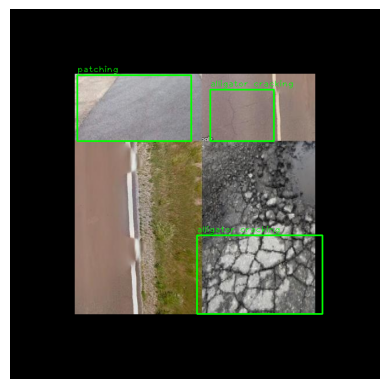

In [15]:
process_image("../valid/asphalt-patch2-e1582666915314_jpg.rf.63f5bd967fe794f6a03ba3487ae3c5d8.jpg", loaded_yolo)